In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import hicstraw
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Import custom libraries
import process_hic_contacts_inter as phc

In [2]:
# Specify directories and relevant information
genome_dir = '/home/louiscam/projects/gpcr/data/genome_data/'
raw_hic_dir = '/home/louiscam/projects/gpcr/data/hic_data/IMR90/'
balanced_hic_dir = '/home/louiscam/projects/gpcr/save/processed_hic_data/'
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
arrowhead_dir = '/home/louiscam/projects/gpcr/save/processed_hic_domains/arrowhead/'
cell_type = 'IMR90'
quality = 'MAPQGE30'
resol = 250000
normalization_list = ['NONE', 'KR']
resolution_list = [5000, 10000, 25000]
chrom_list = np.arange(1, 22+1, 1)

In [3]:
# Pick parameters
normalization = normalization_list[1]
resolution = resolution_list[1]

# Analyze one TAD partition

## Load processed TAD data for all chromosomes

In [4]:
# Load TAD data
fname = arrowhead_dir+f'{normalization}/{resolution}/processed_tads_list.csv'
processed_tads_df = pd.read_csv(fname, header=0, index_col=0)
processed_tads_df.head()

,chromo,start,end,length
0,1,940001,1230000,290000
1,1,1270001,1450000,180000
2,1,1850001,2100000,250000
3,1,2960001,3320000,360000
4,1,3370001,3560000,190000


## Analyze processed TADs

In [5]:
# Display stats
print(f'Total number of TADs = {processed_tads_df.shape[0]}')
print('Descriptive statistics (in kb):')
print((processed_tads_df['length']/1000).describe())

Total number of TADs = 4194
Descriptive statistics (in kb):
count    4194.000000
mean      389.604196
std       307.581886
min       120.000000
25%       210.000000
50%       300.000000
75%       460.000000
max      4190.000000
Name: length, dtype: float64


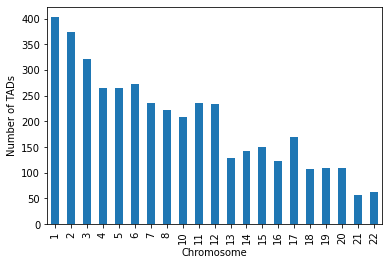

In [6]:
# Number of TADs per chromosome
plt.figure()
processed_tads_df.groupby('chromo').size().plot.bar()
plt.xlabel('Chromosome')
plt.ylabel('Number of TADs')
plt.show()

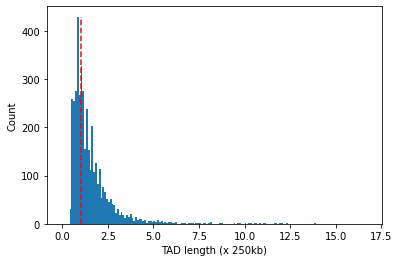

In [7]:
# Distribution of TAD lengths in terms of 250kb
plt.figure()
h = plt.hist(
    processed_tads_df['length']/resol,
    bins=np.arange(0, (processed_tads_df['length']/resol).max(), 0.1)
)
plt.vlines(x=1, ymin=0, ymax=h[0].max(), color='red', linestyle='dashed')
plt.xlabel('TAD length (x 250kb)')
plt.ylabel('Count')
plt.show()

# Compare TAD partitions

In [8]:
# Create dictionary of TADs based on Arrowhead parameters
tads_dict = {}
for normalization, resolution in itertools.product(normalization_list, resolution_list):
    key = f'tad_{normalization}_{resolution}'
    fname = arrowhead_dir+f'{normalization}/{resolution}/processed_tads_list.csv'
    value = pd.read_csv(fname, header=0, index_col=0)
    value = value.reset_index(drop=True)
    tads_dict[key] = value

## Measure of concordance

### Using off-the-shelf MoC function

In [9]:
# Load MoC data for all chromosomes
moc_df_ls = []
for chrom in chrom_list:
    fname = arrowhead_dir+f'TAD_concordance_results/chr{chrom}_moc.csv'
    moc_chrom_df = pd.read_csv(fname, header=0, sep='\t')
    moc_df_ls.append(moc_chrom_df)
moc_df = pd.concat(moc_df_ls)

In [10]:
# Create MoC heatmap
grouped_moc_df = moc_df.groupby(['tad_list1', 'tad_list2'])['moc'].mean()
grouped_moc_df = grouped_moc_df.reset_index()
grouped_moc_df = grouped_moc_df.set_index(['tad_list1', 'tad_list2'])
moc_heatmap_df = grouped_moc_df.unstack()
moc_heatmap_df = moc_heatmap_df.droplevel(0, axis=1)

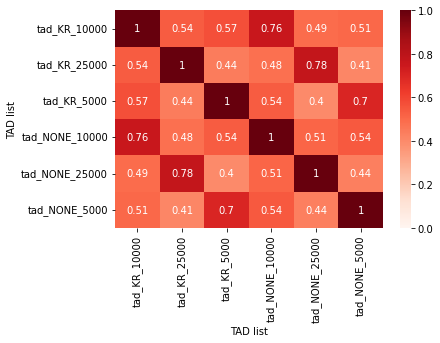

In [12]:
# Display MoC heatmap
plt.figure()
sns.heatmap(
    data=moc_heatmap_df,
    annot=True,
    cmap='Reds',
    vmin=0,
    vmax=1
)
plt.xlabel('TAD list')
plt.ylabel('TAD list')
plt.show()

### Using custom implementation of MoC function

In [16]:
# Measure of concordance for 2 TADs
def moc(tad1_chrom, tad1_start, tad1_end, tad2_chrom, tad2_start, tad2_end):
    
    if (tad1_chrom==tad2_chrom):
        x = tad1_end-tad1_start+1
        y = tad2_end-tad2_start+1
        
        if (tad2_start>=tad1_start) & (tad2_start<=tad1_end) & (tad2_end>=tad1_start) & (tad2_end<=tad1_end):
            intersection = tad2_end-tad2_start
        elif (tad2_start>=tad1_start) & (tad2_start<=tad1_end) & (tad2_end>tad1_end):
            intersection = tad1_end-tad2_start
        elif (tad2_start>=tad1_end):
            intersection = 0
        elif (tad1_start>=tad2_start) & (tad1_start<=tad2_end) & (tad1_end>=tad2_start) & (tad1_end<=tad2_end):
            intersection = tad1_end-tad1_start
        elif (tad1_start>=tad2_start) & (tad1_start<=tad2_end) & (tad1_end>tad2_end):
            intersection = tad2_end-tad1_start
        elif (tad1_start>=tad2_end):
            intersection = 0
        
        out = (intersection**2)/(x*y)
    else:
        out = 0
    
    return(out)

In [17]:
# Measure of concordance between 2 TAD lists (see https://www.nature.com/articles/s41588-018-0338-y)
def moc_tad_lists(key_tad_list_1, key_tad_list_2, tads_dict, chrom_list):
    
    tads_df1 = tads_dict[key_tad_list_1]
    tads_df2 = tads_dict[key_tad_list_2]
    
    for chrom in chrom_list:
        
        moc_list = []
        out_list = []
        
        index1 = tads_df1[tads_df1['chromo']==chrom].index
        index2 = tads_df2[tads_df2['chromo']==chrom].index
        
        for idx1, idx2 in itertools.product(index1, index2):

            tad1_chrom = tads_df1.loc[idx1, 'chromo']
            tad1_start = tads_df1.loc[idx1, 'start']
            tad1_end = tads_df1.loc[idx1, 'end']
            tad2_chrom = tads_df2.loc[idx2, 'chromo']
            tad2_start = tads_df2.loc[idx2, 'start']
            tad2_end = tads_df2.loc[idx2, 'end']

            moc_value = moc(tad1_chrom, tad1_start, tad1_end, tad2_chrom, tad2_start, tad2_end)
            moc_list.append(moc_value)
        
        out_chrom = np.sum(moc_list)/(np.sqrt(len(index1)*len(index2))-1)
        out_list.append(out_chrom)
        
    out = np.average(out_list)
    return(key_tad_list_1, key_tad_list_2, out)

In [18]:
# Compute MoC for our TADs lists
out = Parallel(n_jobs = os.cpu_count()-1, backend='loky')(
    delayed(moc_tad_lists)(
        key_tad_list_1, key_tad_list_2, tads_dict, chrom_list
    ) for (key_tad_list_1, key_tad_list_2) in tqdm(list(itertools.combinations(tads_dict.keys(), 2)))
)

In [19]:
# Structure and save results as a dataframe
moc_df = pd.DataFrame(0, index=tads_dict.keys(), columns=tads_dict.keys())
for idx1, idx2, v in out:
    moc_df.loc[idx1, idx2] = v
    moc_df.loc[idx2, idx1] = v
    moc_df.loc[idx1, idx1] = 1
    moc_df.loc[idx2, idx2] = 1

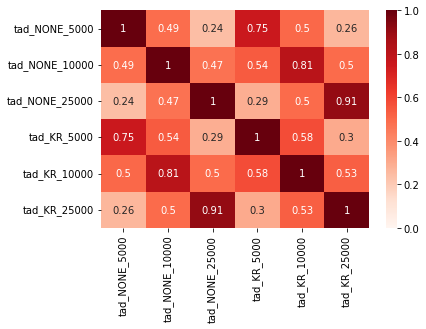

In [20]:
# Display MoC heatmap
plt.figure()
sns.heatmap(
    data=moc_df,
    annot=True,
    cmap='Reds',
    vmin=0,
    vmax=1
)
plt.show()

## Enrichment of structural proteins at TAD boundaries

In [13]:
# For every TAD list, collect the enrichment for 3 structural proteins (jointly for all chromosomes)

enrichment_dict = {}
for normalization in normalization_list:
    
    for resolution in resolution_list:
        resolution_kb = resolution//1000
        enrichment_chrom_list = []
        
        for chrom in chrom_list:
            fname = f'{arrowhead_dir}{normalization}/{resolution}/{chrom}/StructProteins_chr{chrom}_res{resolution_kb}kb.txt'
            
            if os.path.exists(fname):
                enrichment_chrom_df = pd.read_csv(fname, sep='\t', header=0)
                enrichment_chrom_df.loc[:, 'chrom'] = chrom
                enrichment_chrom_df.loc[:, 'normalization'] = normalization
                enrichment_chrom_df.loc[:, 'resolution'] = resolution
                enrichment_chrom_df.loc[:, 'neglogpval_of_peak'] = -np.log10(enrichment_chrom_df['pval_of_peak'])
                enrichment_chrom_df = enrichment_chrom_df[
                    ['chrom', 'normalization', 'resolution', 'resolution_kb', 'protein', 'domains_ratio', 'fc_over_bg', 'neglogpval_of_peak']
                ]
                enrichment_chrom_list.append(enrichment_chrom_df)
        
        value = pd.concat(enrichment_chrom_list)
        value = value.reset_index(drop=True)
        key = f'tad_{normalization}_{resolution}'
        enrichment_dict[key] = value

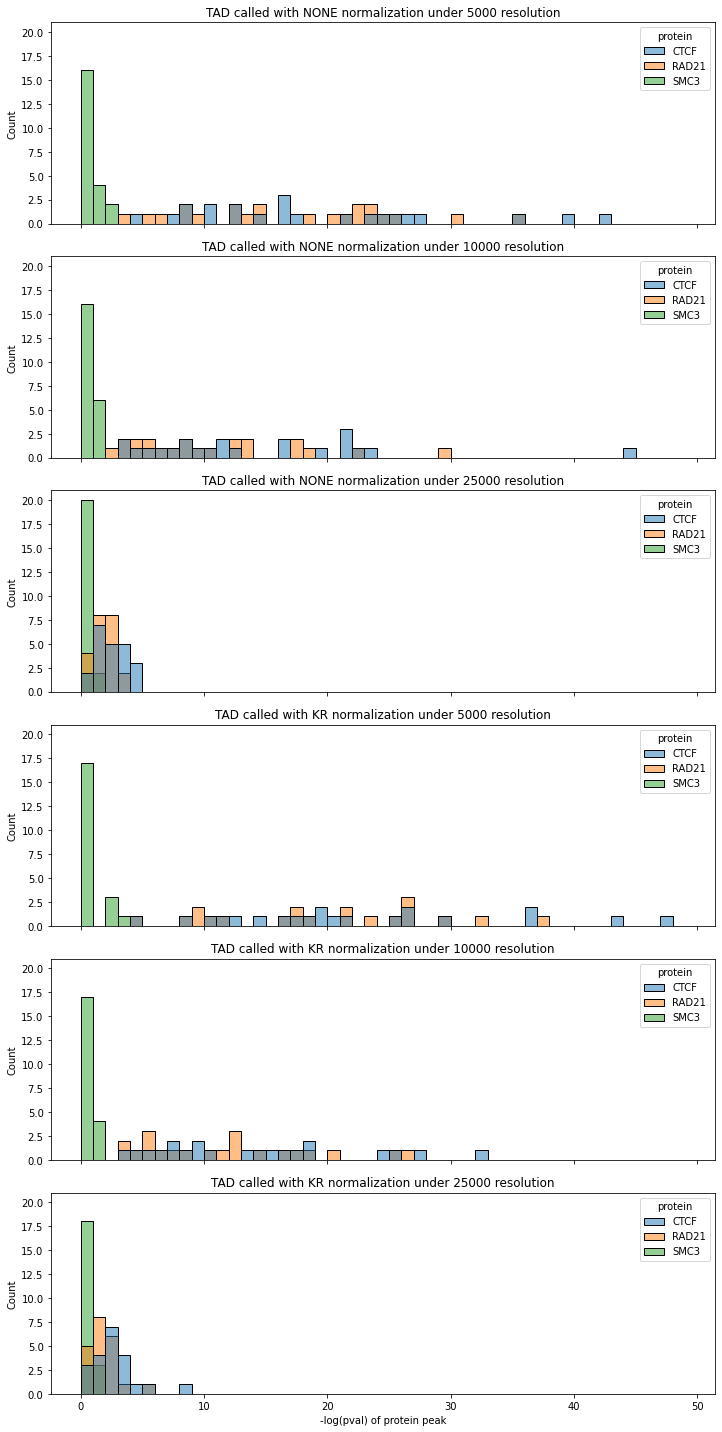

In [15]:
# Compare TAD lists for each (normalization, reoslution) setting using distribution of protein peak p-values
fig, axes = plt.subplots(nrows=len(enrichment_dict.keys()), ncols=1, figsize=(10, 20), sharex=True, sharey=True)

# Plot the histograms on each subplot
for i, k in enumerate(enrichment_dict.keys()):
    _, normalization, resolution = k.split('_')
    sns.histplot(
        data=enrichment_dict[k], 
        x='neglogpval_of_peak', 
        hue='protein',
        bins=np.arange(0, 50, 1),
        ax=axes[i]
    )
    axes[i].set_title(f'TAD called with {normalization} normalization under {resolution} resolution')

# Set common x-axis label
plt.xlabel('-log(pval) of protein peak')

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()

##  Enrichment of either Activating or Repressing Histone Marks within TADs

In [16]:
# For every TAD list, collect the results of the histone enrichment analysis

histone_enrichment_dict = {}
for normalization in normalization_list:
    
    for resolution in resolution_list:
        histone_enrichment_chrom_list = []
        
        for chrom in chrom_list:
            fname = f'{arrowhead_dir}{normalization}/{resolution}/{chrom}/Results_df_shuf10_share0.1_fdrthresh0.1.txt'
            
            if os.path.exists(fname):
                histone_enrichment_chrom_df = pd.read_csv(fname, sep='\t', header=0)
                histone_enrichment_chrom_df.loc[:, 'chrom'] = chrom
                histone_enrichment_chrom_df.loc[:, 'normalization'] = normalization
                histone_enrichment_chrom_df.loc[:, 'resolution'] = resolution
                histone_enrichment_chrom_df = histone_enrichment_chrom_df[
                    ['chrom', 'normalization', 'resolution', 'nTads', 'binsize', 'shareTadsSignif_lr_BH']
                ]
                histone_enrichment_chrom_list.append(histone_enrichment_chrom_df)
        
        value = pd.concat(histone_enrichment_chrom_list)
        value = value.reset_index(drop=True)
        key = f'tad_{normalization}_{resolution}'
        histone_enrichment_dict[key] = value

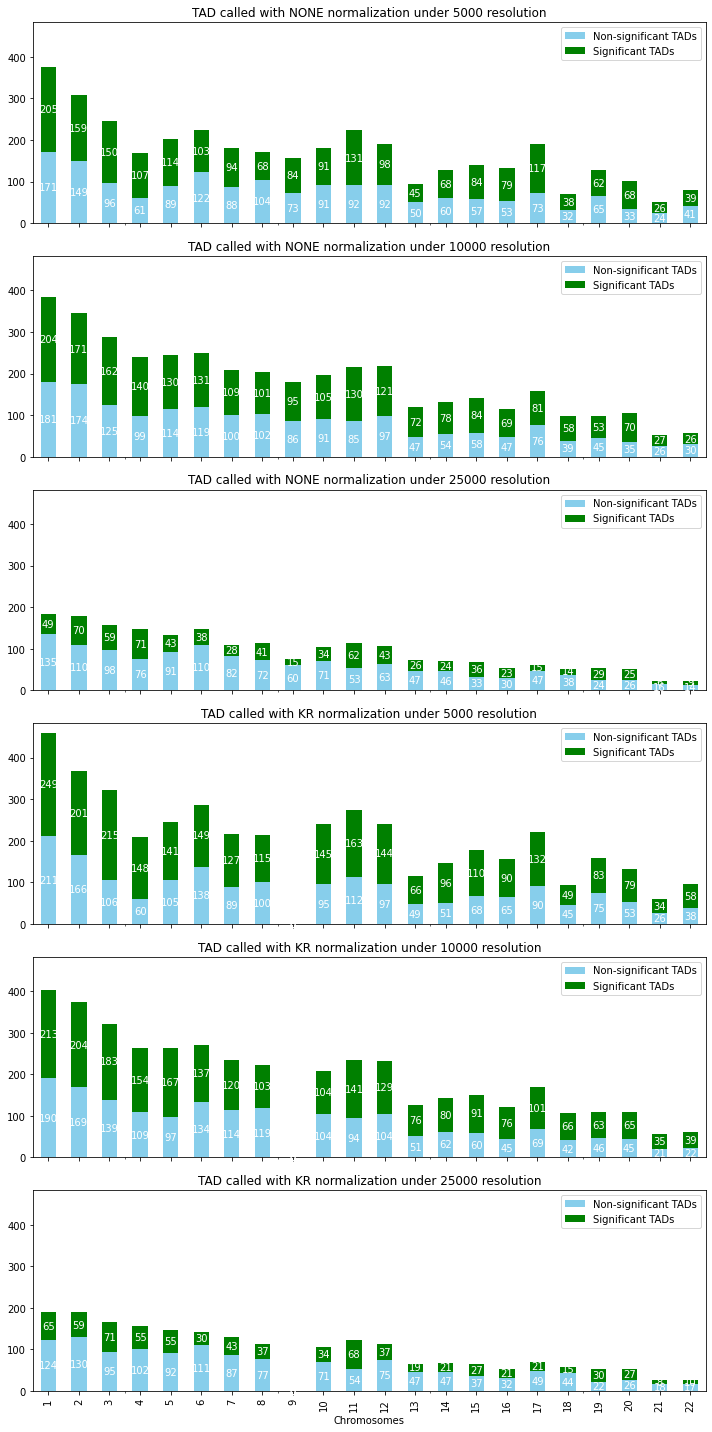

In [17]:
# Compare TAD lists for each (normalization, reoslution) setting using fraction of histone-enriched TADs
fig, axes = plt.subplots(nrows=len(histone_enrichment_dict.keys()), ncols=1, figsize=(10, 20), 
                         sharex=True, sharey=True)

# Plot the histograms on each subplot
for i, k in enumerate(histone_enrichment_dict.keys()):
    # Draw stacked barplot
    _, normalization, resolution = k.split('_')
    df = histone_enrichment_dict[k]
    df = df.set_index('chrom')
    df.loc[:, 'Significant TADs'] = (df['nTads']*df['shareTadsSignif_lr_BH']).astype(int)
    df.loc[:, 'Non-significant TADs'] = df['nTads']-df['Significant TADs']
    df = df[['Non-significant TADs', 'Significant TADs']]
    # Check if all chromosomes are present -- if not, add 0 size
    for chrom in list(set(chrom_list)-set(df.index)):
        df.loc[chrom, :] = [0, 0]
    df = df.sort_index().astype(int)
    df.plot(
        kind='bar', 
        stacked=True, 
        color=['skyblue', 'green'],
        
        ax=axes[i]
    )
    axes[i].set_title(f'TAD called with {normalization} normalization under {resolution} resolution')
    
    # Add values
    for container in axes[i].containers:
        for rect in container:
            width = rect.get_width()
            height = rect.get_height()
            x = rect.get_x() + width / 2
            y = rect.get_y() + height / 2
            label = int(height)
            axes[i].annotate(label, (x, y), ha='center', va='center', color='w')

# Set common x-axis label
plt.xlabel('Chromosomes')

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()